# The diffusion constant

In this notebook we'll measure the diffusion constant by looking at the mean squared displacement of every atom in an Argon gas. That is, we compute the mean squared displacement from
\begin{align}
    \langle r^2(t) \rangle
    = \frac{1}{N} \sum_{i = 1}^{N} \left(
        \mathbf{r}_i(t) - \mathbf{r}_i(t_0)
    \right)^2,
\end{align}
where $t_0$ is the time at the start of the simulation. Computing the displacement at every time step can prove hard due to periodic boundary conditions. Luckily, Lammps can compute the quantity for us!

In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model

sns.set(color_codes=True)

In [38]:
%%writefile scripts/diffusion.in

# 3d Lennard-Jones gas
units lj
dimension 3
timestep 0.005
# Periodic boundiaries
boundary p p p
atom_style atomic

variable sigma equal 3.405
variable b equal 15
variable reduced_density equal 4/((${b}/${sigma})^3)


lattice fcc ${reduced_density}
region simbox block 0 10 0 10 0 10
create_box 1 simbox
create_atoms 1 box

mass 1 1.0
velocity all create ${T} 87287

pair_style lj/cut 3.0
pair_coeff 1 1 1.0 1.0 3.0

fix 1 all nvt temp ${T} ${T} 3.0
#fix 1 all nve

thermo 10
run 5000


reset_timestep 0
variable mytime equal dt*step
compute msd all msd
thermo_style custom step temp time v_mytime press ke pe etotal c_msd[4]

log dat/diffusion_${T}.log

run 10000

Overwriting scripts/diffusion.in


In [44]:
%%writefile scripts/argon_diffusion.in

export OMP_NUM_THREADS=4

for T in $(seq 0.01 0.1 0.9) $(seq 1 21); do
    mpirun -np 4 lmp -var T $T -in scripts/diffusion.in
done

Overwriting scripts/argon_diffusion.in


In [49]:
file_list = list(filter(lambda x: x.startswith("diffusion"), os.listdir("dat")))

pattern = r"diffusion_(.+).log"
temperature_list = [float(re.search(pattern, filename).group(1)) for filename in file_list]

file_list = list(map(lambda x: os.path.join("dat", x), file_list))

temperature_list, file_list = zip(*sorted(zip(temperature_list, file_list)))

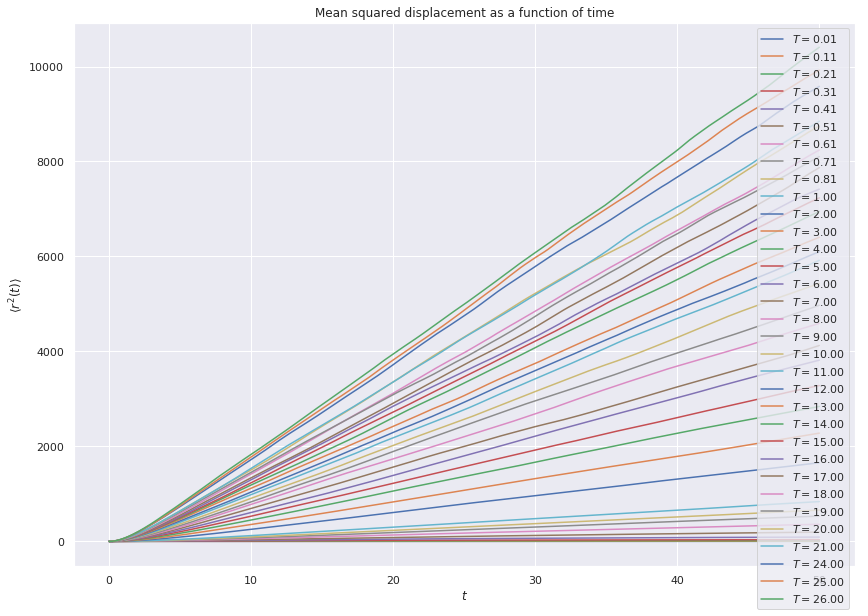

In [50]:
fig = plt.figure(figsize=(14, 10))

log_df_list = []

for T, filename in zip(temperature_list, file_list):
    log_df = pd.read_csv(filename, sep=r"\s+", skiprows=3, skipfooter=27, engine="python")
    log_df_list.append(log_df)
    plt.plot(
        log_df["v_mytime"],
        log_df["c_msd[4]"],
        label=fr"$T = {T:.2f}$"
    )

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle r^2(t)\rangle$")
plt.legend(loc="best")
plt.title(r"Mean squared displacement as a function of time")
plt.show()

In this plot we see the mean squared displacement plotted against time. When $t$ is larger than some threshold $t_t$ we see that the expected linear relationship
\begin{align}
    \langle r^2(t) \rangle = 6 D(T) t,
\end{align}
is achieved. However, when $t$ is close to the initial time $t_0$ we get _anomlous diffusion_, that is, the mean squared displacement is not a linear function of time. As long as $t < t_t$ the mean squared displacement experiences _superdiffusion_, that is,
\begin{align}
    \langle r^2 (t) \rangle \propto t^{\alpha},
\end{align}
where $\alpha > 1$. As it is hard to determine _exactly_ where $t_t$ is located, we will look at $t \gg t_t$ for the linear diffusion and $t \ll t_t$ for the superdiffusion.

In [51]:
t_t = 20 # We define this to be the transition from anomalous to linear diffusion

In [52]:
D_list = []
alpha_list = []

for T, log_df in zip(temperature_list, log_df_list):
    linear_df = log_df[log_df["v_mytime"] > t_t * 2]
    time = np.array(linear_df["v_mytime"])
    msd = np.array(linear_df["c_msd[4]"])
    
    clf = sklearn.linear_model.LinearRegression().fit(
        time[:, np.newaxis], msd[:, np.newaxis]
    )
    D_list.append(clf.coef_[0, 0] / 6)

    super_df = log_df[(log_df["v_mytime"] < t_t / 2) & (log_df["v_mytime"] > 0)]
    time = np.log(super_df["v_mytime"])
    msd = np.log(super_df["c_msd[4]"])

    clf = sklearn.linear_model.LinearRegression().fit(
        time[:, np.newaxis], msd[:, np.newaxis]
    )
    alpha_list.append(clf.coef_[0, 0])

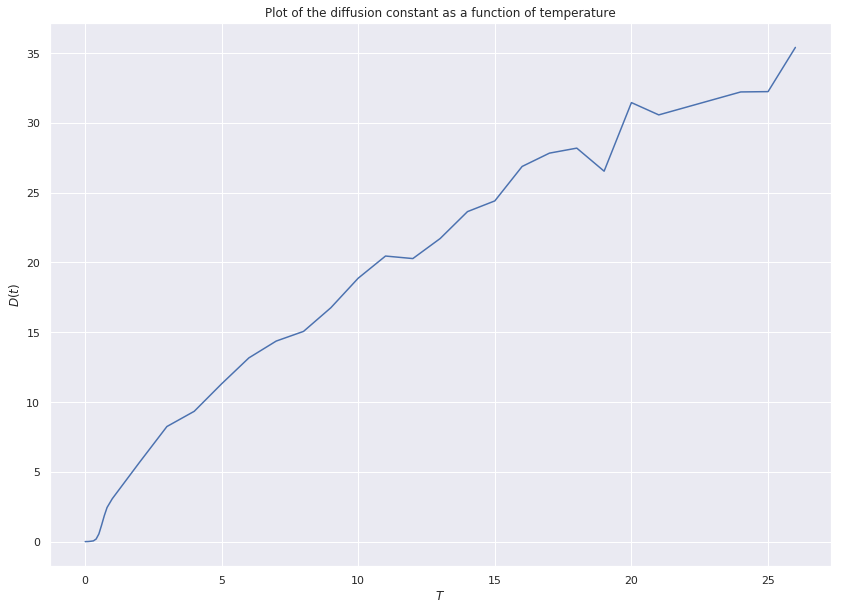

In [53]:
fig = plt.figure(figsize=(14, 10))

plt.plot(temperature_list, D_list)
plt.title(r"Plot of the diffusion constant as a function of temperature")
plt.xlabel(r"$T$")
plt.ylabel(r"$D(t)$")
plt.show()

In this figure we can see how the diffusion constant follows a linear relationship with the temperature $T$ after the anomalous diffusion period.